<a href="https://colab.research.google.com/github/katreeder/wine-classification/blob/main/Group33_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Quality of Red Wine Using K-Nearest-Neighbours

Wine connoisseurs are a class of professionals that use their senses and their industry expertise to assess the quality of a given wine. In this process, connoisseurs judge wine quality based on their perceptions of the sensory and physicochemical attributes of the wine. Sensory factors include color and aroma, while physicochemical attributes include variables such as sugar content, pH, and alcohol strength (Daiko, 2016). After tasting the wine, a critic will assign the wine a quality rating on a 100 point scale. 

However, human senses are not the most precise analytical tools. A wine critic’s perception of wine quality can be influenced by extraneous factors such as the reputation of the vineyard or the setting of consumption. For the purposes of consistent quality assurance, it would be useful if there were a correlation between measurable chemical attributes and wine quality, as such a relationship would allow for wine quality ratings to be cross-referenced in an independent lab setting. 

This analysis explores the following research question: can the chemical attributes of red wine be used to determine red wine quality using KNN classification? To answer this question, our team will use the ‘Wine Quality’ dataset from the UCI Machine Learning Laboratory to build a classification model that predicts a target class or red wine quality (UCI, 2017). The Wine Quality dataset contains contains 1599 observations, and several chemical attributes of red wines, such as acidity, sugar levels, and alcohol content. The dataset also includes a quality rating which ranks each  wine on a scale of 1-10.  

# Loading the Dataset


In [ ]:
# These are here in case the environment doesn't have these packages installed.
# If they aren't already installed, installing them may take a few minutes.
if (!"tidymodels" %in% rownames(installed.packages())) {
    install.packages("tidymodels")
}
if (!"kknn" %in% rownames(installed.packages())) {
    install.packages("kknn")
}
if (!"GGally" %in% rownames(installed.packages())) {
    install.packages("GGally")
}
library("tidyverse")
library("tidymodels")
library("knitr")
library("GGally")


Using the `read_delim` function we're able to load the dataset from its original source on the web. 



In [ ]:
wine_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", delim = ";")



── Column specification ────────────────────────────────────────────────────────
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)




# Cleaning the Data
While Wine Quality dataset is fairly tidy we will take the following steps to achieve the format necessary for our analysis.

- We use `na.omit` to remove incomplete observations from the dataset. 
- Using `colnames` and `make.names` to mutate the column names into a format that is manipulatable in R

In [ ]:
wine_data <- wine_data %>% na.omit()

colnames(wine_data) = make.names(colnames(wine_data))

head(wine_data)

fixed.acidity volatile.acidity citric.acid residual.sugar chlorides
1  7.4          0.70             0.00        1.9            0.076    
2  7.8          0.88             0.00        2.6            0.098    
3  7.8          0.76             0.04        2.3            0.092    
4 11.2          0.28             0.56        1.9            0.075    
5  7.4          0.70             0.00        1.9            0.076    
6  7.4          0.66             0.00        1.8            0.075    
  free.sulfur.dioxide total.sulfur.dioxide density pH   sulphates alcohol
1 11                  34                   0.9978  3.51 0.56      9.4    
2 25                  67                   0.9968  3.20 0.68      9.8    
3 15                  54                   0.9970  3.26 0.65      9.8    
4 17                  60                   0.9980  3.16 0.58      9.8    
5 11                  34                   0.9978  3.51 0.56      9.4    
6 13                  40                   0.9978  3.51 0.56      9.4    
  quality
1 5      
2 5      
3 5      
4 6      
5 5      
6 5

# Exploratory Analysis
We know that K-nearest neighbour classification does not perform well if class observations are imbalanced. So we need to check if observations of quality ratings are proportionate to reduce bias in our classification analysis. We then use `kable` to neatly organize and label the table.   

In [ ]:
# Count the number of observations in each class
num_each_class <- wine_data %>%
    group_by(quality) %>%
    summarize(num = n())

# Show observation count nicely
# This just also serves as a double check that the data is loaded in properly
kable(num_each_class, 
      caption = "The Number of Observations per Quality Level", 
      col.names = c("Quality", "Observation Count"), align = "ll")

`summarise()` ungrouping output (override with `.groups` argument)





Table: The Number of Observations per Quality Level

|Quality |Observation Count |
|:-------|:-----------------|
|3       |10                |
|4       |53                |
|5       |681               |
|6       |638               |
|7       |199               |
|8       |18                |

As we can see, classes 5 and 6 have the most observations in the dataset. We will have to correct this later on when we standardize the dataset. 

The next step of our exploratory analysis is to determine the variables that are most important in predicting the quality of wine. We used `ggpairs` to create a summary of correlations.

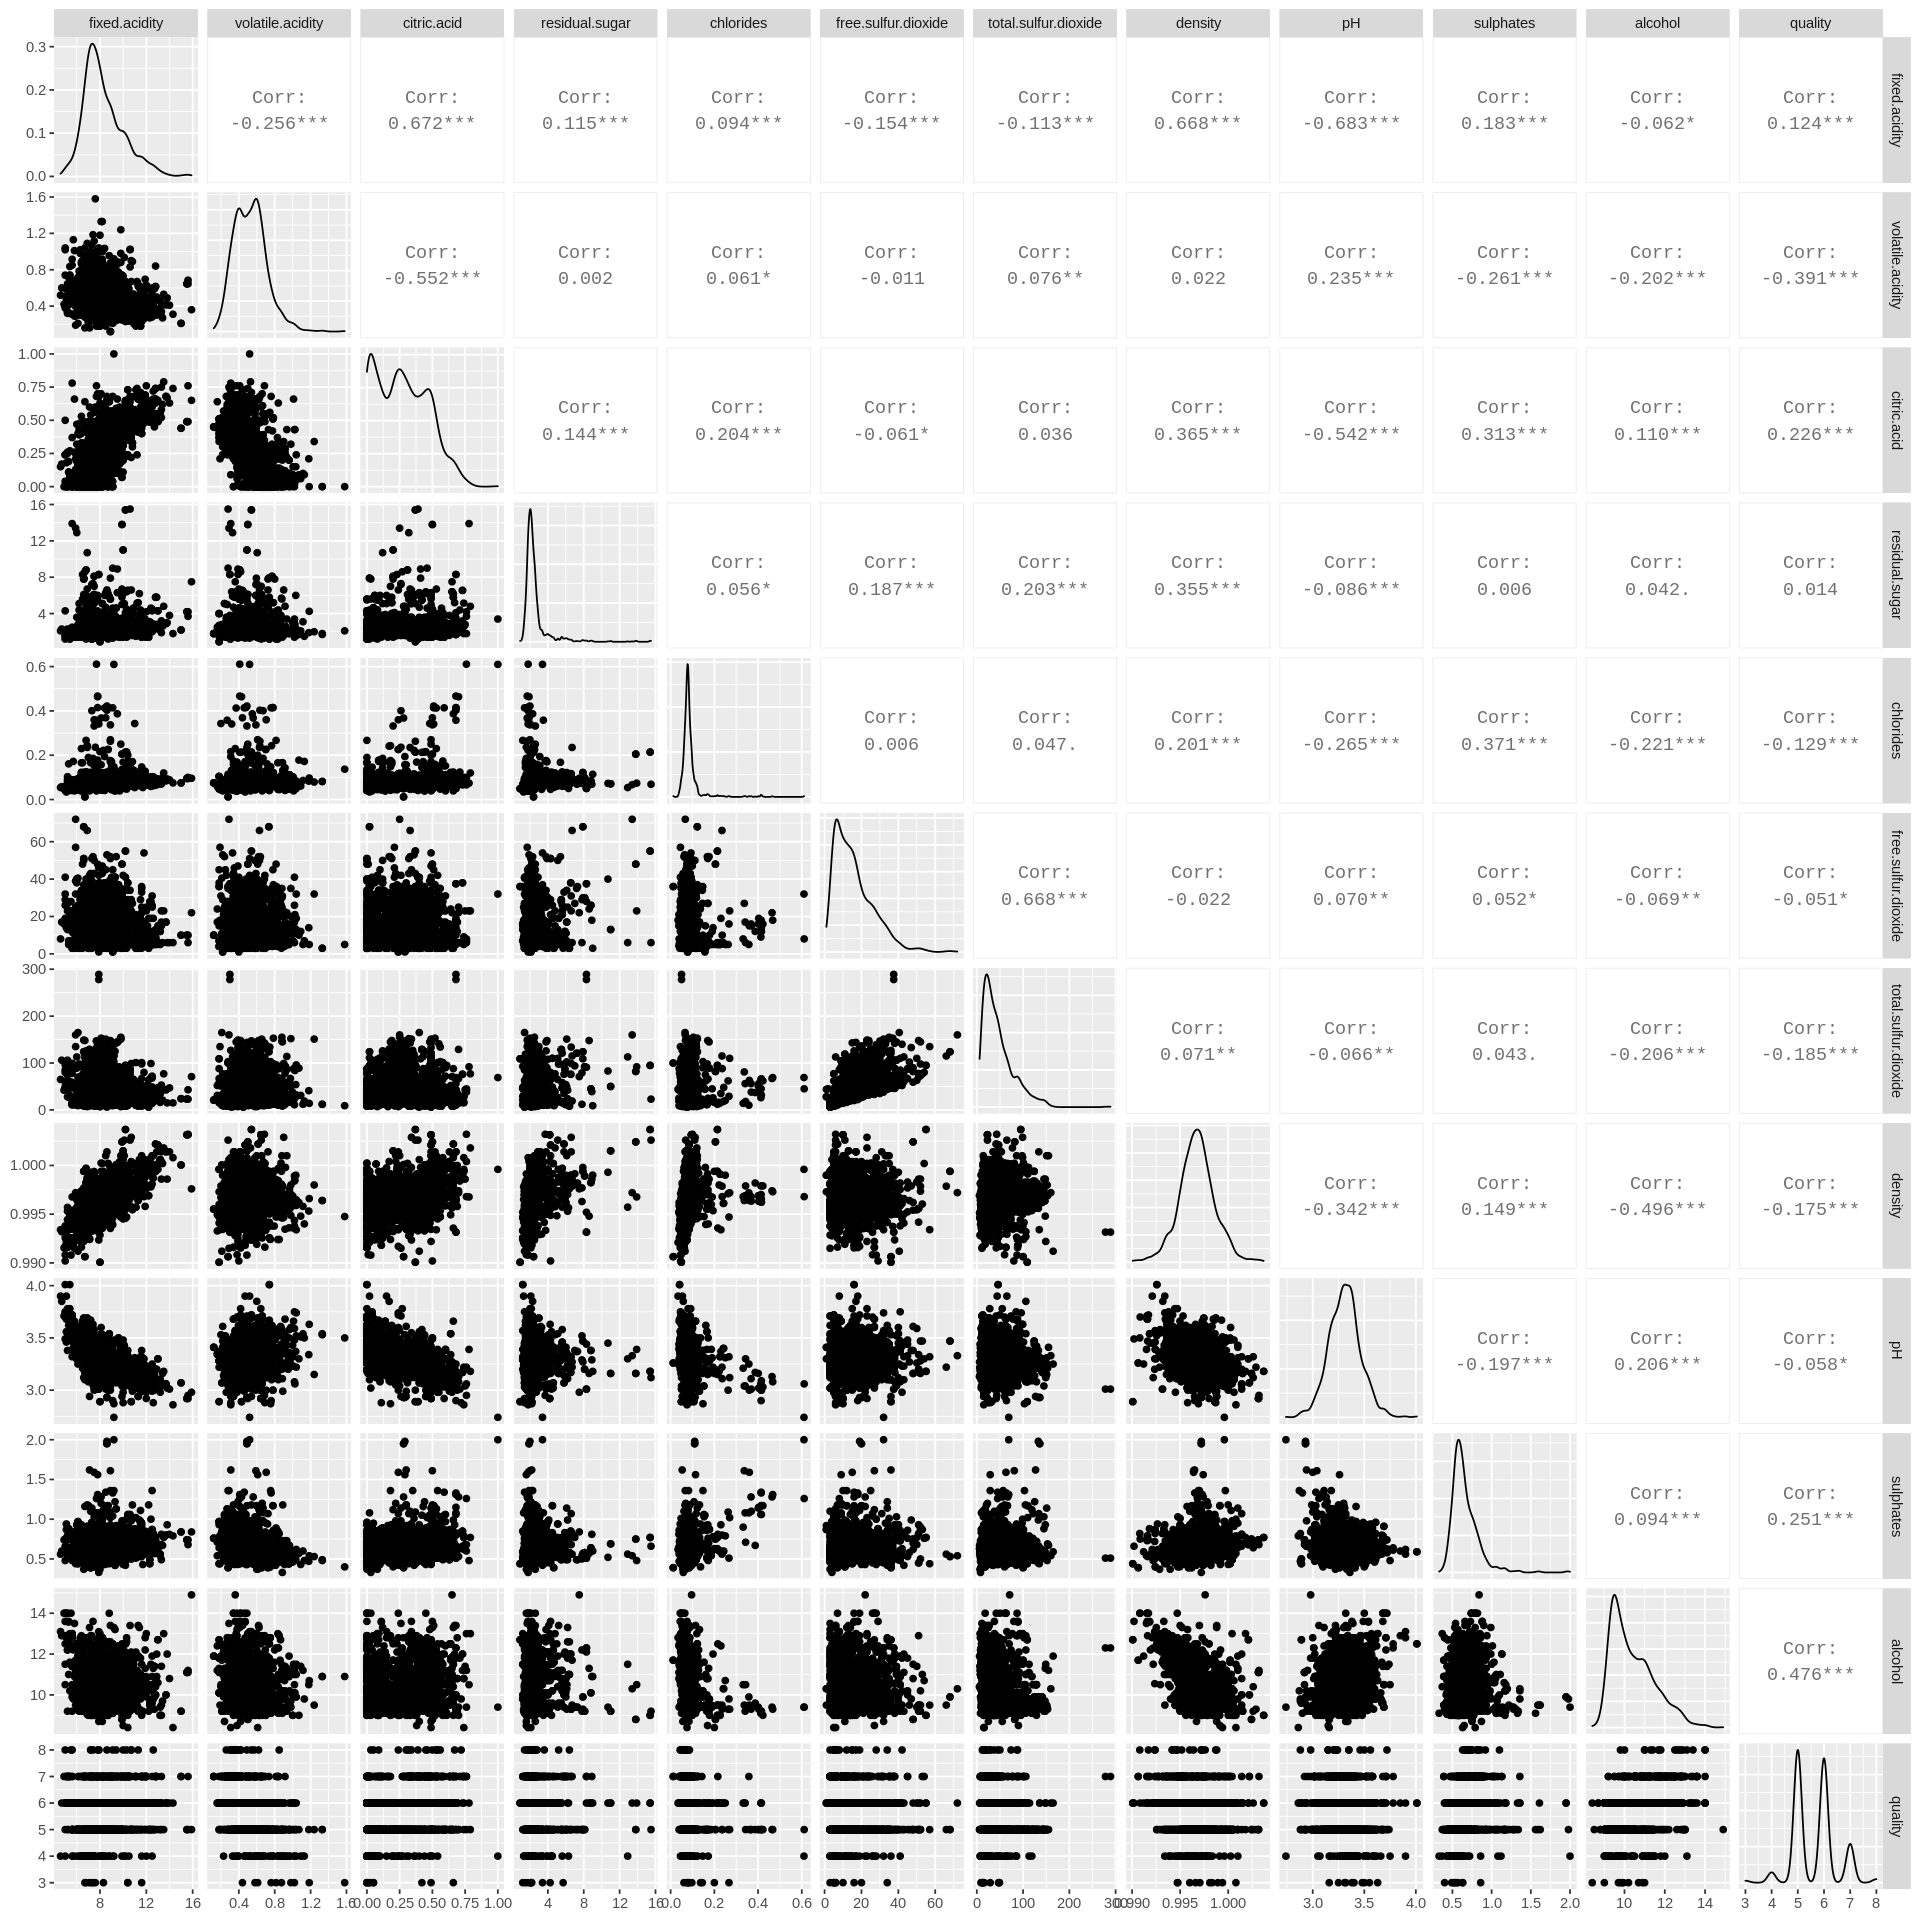

In [ ]:
options(repr.plot.width = 16, repr.plot.height = 16)

wine_stats <- ggpairs(wine_data)

wine_stats

To get just the correlation of predictor variables to wine quality, we use `as.data.frame` and `rownames_to_column` to organize it into a table and `arrange` to make it in descending order of strongest correlation. 

In [ ]:
# Calculate correlation coefficients between quality and predictors
correlation_coefficients <- as.data.frame(cor(wine_data)[,"quality"]) %>%
    # Rename variable column
    tibble::rownames_to_column("var")

# Rename correlation coefficients column
colnames(correlation_coefficients)[2] = "cor"

# Arrange coefficients in descending order of their magnitude
correlation_coefficients <- correlation_coefficients %>%
    arrange(desc(abs(cor))) %>%
    filter(var != "quality")

# Show nice table of correlation coefficients
kable(correlation_coefficients,
      caption = "The Correlation Between Each Predictor and Quality",
      col.names = c("Variable", "Correlation"))



Table: The Correlation Between Each Predictor and Quality

|Variable             | Correlation|
|:--------------------|-----------:|
|alcohol              |   0.4761663|
|volatile.acidity     |  -0.3905578|
|sulphates            |   0.2513971|
|citric.acid          |   0.2263725|
|total.sulfur.dioxide |  -0.1851003|
|density              |  -0.1749192|
|chlorides            |  -0.1289066|
|fixed.acidity        |   0.1240516|
|pH                   |  -0.0577314|
|free.sulfur.dioxide  |  -0.0506561|
|residual.sugar       |   0.0137316|

As we've learned, K-nearest neighbour classification does not perform well with a large number of predictor variables so we've decided to pick the 2 variables with the strongest correlation, alcohol and volatile acidity. This also makes it easier to visualize the predictions of the K-nearest neighbour model later on. 

To further explore the predictor variables we've chosen, we decided to plot wine quality against the variables so we can see if there is a distinct difference in low and high quality wine. Since observations of wine quality is disproportionate in our dataset, we decided to explore the means of each predictor grouped by the wine quality rating. 


`summarise()` regrouping output by 'quality' (override with `.groups` argument)



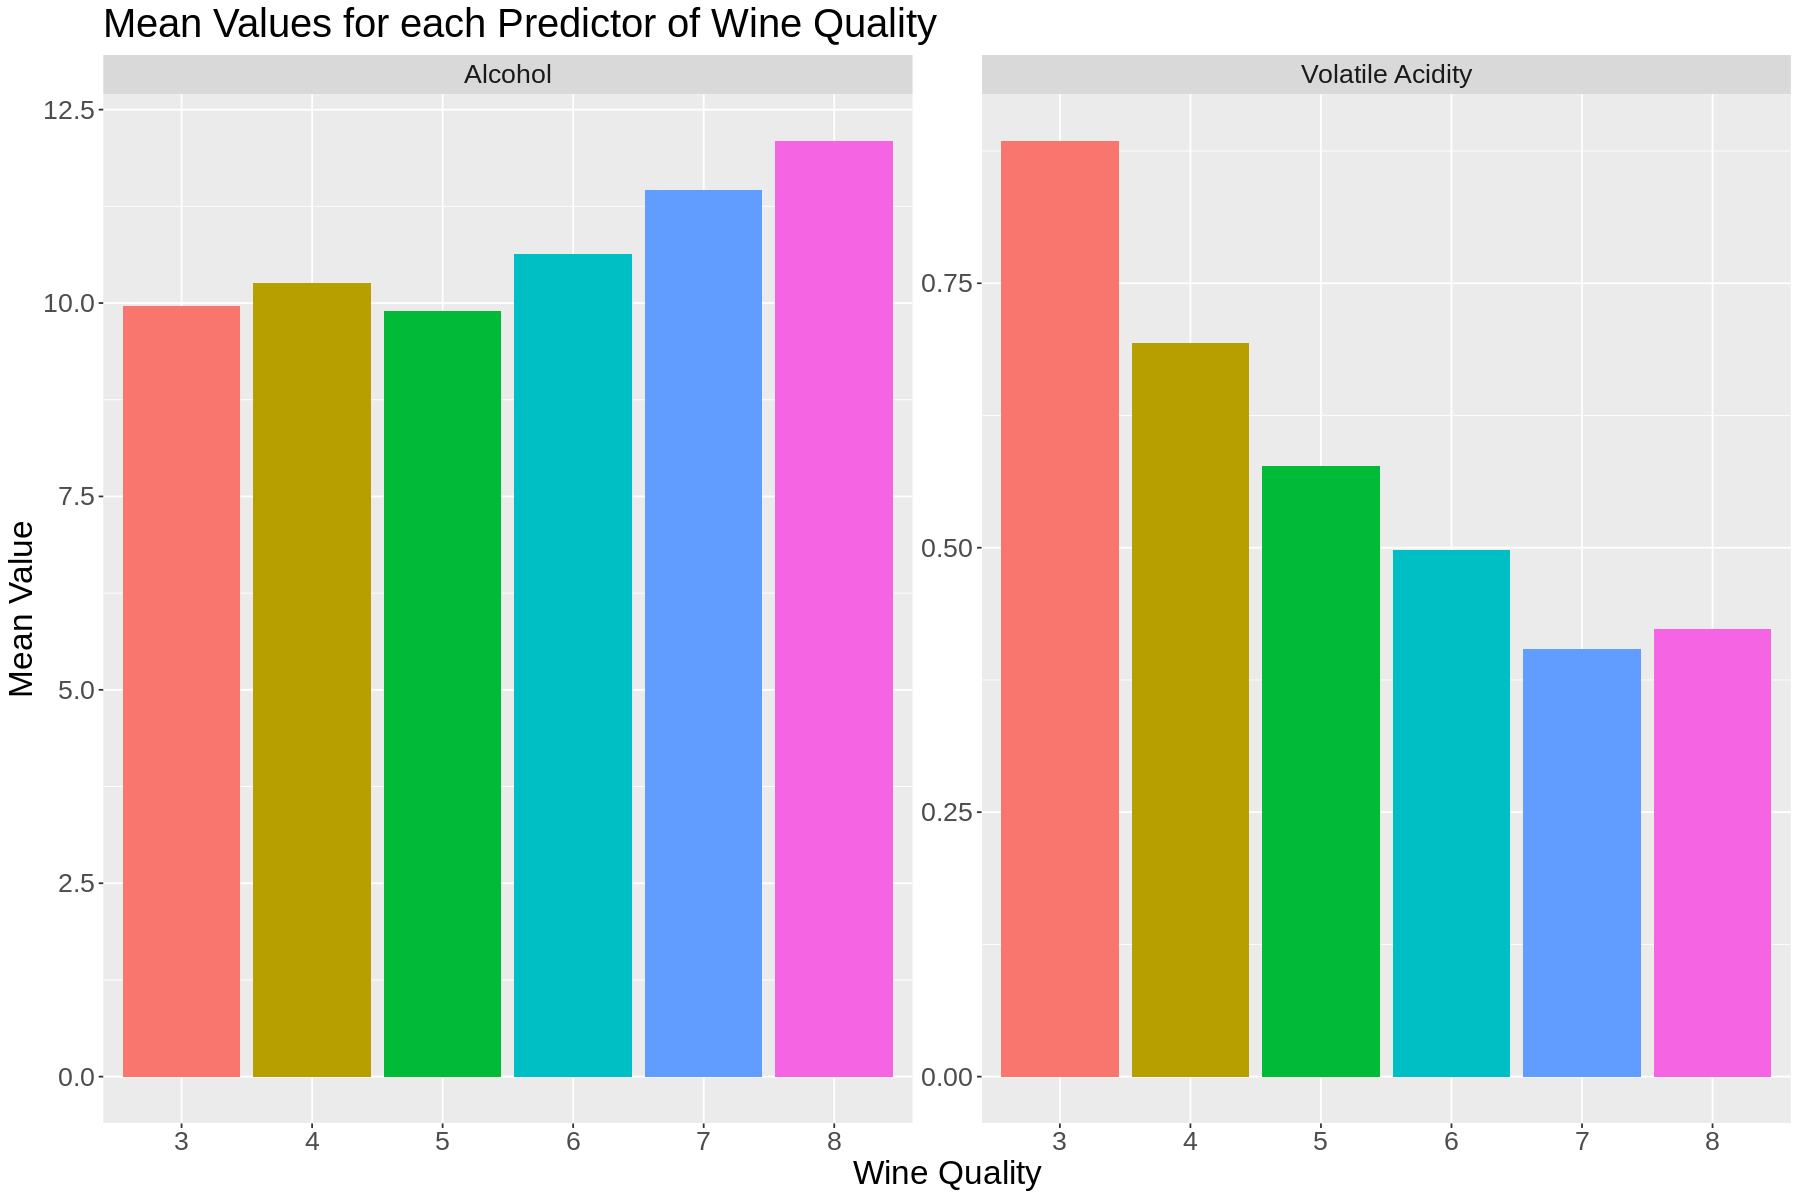

In [ ]:
# Now that we know which predictors we actually want to use we can select them
# and since we want to use quality as our categorical statistical variable, 
# we use as_factor to convert the variable to a factor in wine_data.

wine_data <- wine_data %>%
    mutate(quality = as_factor(quality)) %>%
    select(quality, alcohol, volatile.acidity)

options(repr.plot.width = 15, repr.plot.height = 10)

# Create labels for each predictor
facet_labels <- c("Alcohol", "Volatile Acidity")
names(facet_labels) <- c("alcohol", "volatile.acidity")

# Gather predictors into key-value pairs then plot the mean values for each
# predictor
means_plot <- wine_data %>%
    gather(key = "predictor", value = "value", -quality) %>%
    group_by(quality, predictor) %>%
    summarize(mean = mean(value), max = max(value), min = min(value)) %>%
    ggplot(aes(x = quality, y = mean, fill = quality)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    facet_wrap( ~ predictor, scales = "free", labeller = labeller(predictor = facet_labels)) +
    labs(x = "Wine Quality", y = "Mean Value", title = "Mean Values for each Predictor of Wine Quality") +
    theme(text = element_text(size = 20))

means_plot




We found that alcohol has a clear difference when comparing the lowest and highest end. As indicated on our ggpairs plot, when the alcohol level increases, we can see that it correlates to a higher rating. This means that it is a good predictor for classifying wine quality.

Meanwhile, we can confirm that volatile acidity is negatively correlated to wine quality. Based on the plot, the difference in volatile acidity among wine qualty ratings is noticeable which means that this could be a good predictor to classify wine. 

# Wine Quality Classification Analysis with K-Nearest-Neighbours
To build our classifier, we will need to create our training set and test set. We then split our data into training and test sets by 80% and 20% respectively using `initial_split`, `training`, and `testing` functions. 


In [ ]:
set.seed(314159265)
wine_split <- initial_split(wine_data, prop = 0.8, strata = quality)
wine_train <- training(wine_split)
wine_test <- testing(wine_split)


Earlier, we discovered that proportion of wine classes in our dataset is imbalanced. This is why we use `step_upsample` in our recipe to give classes with less observations more voting power in the K-nearest neighbor algorithm. We also scale our predictor variables using `step_scale` and `step_center` so that the dataset has a mean of 0 and a standard deviation of 1 to avoid errors in area measurements. 

In [ ]:
wine_recipe <- recipe(quality ~ alcohol + volatile.acidity, data = wine_train) %>%
    step_upsample(quality, over_ratio = 0.2) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

wine_recipe

Warning message:
“`step_upsample()` is deprecated as of recipes 0.1.13.
Please use `themis::step_upsample()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Up-sampling based on quality
Scaling for all_predictors()
Centering for all_predictors()

#Tuning the Model

We will need to tune our classifier and find the most optimal number of neighbours K for the training data by using cross validation. We use 5-fold cross validation with the `vfold_cv` function. In the model specification (`wine_tune`), we specify `neighbors = tune()` since we are going to tune each parameter in the model. To get the accuracy of each parameter value, we use the `tune_grid` function to fit the model for the range of parameter values(30) and `collect_metrics` to aggregate the validation's accuracy across the folds. Once we have the mean of the parameter values' accuracy, we plot the accuracy of number of neighbours.



Attaching package: ‘rlang’


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice



Attaching package: ‘vctrs’


The following object is masked from ‘package:dplyr’:

    data_frame


The following object is masked from ‘package:tibble’:

    data_frame




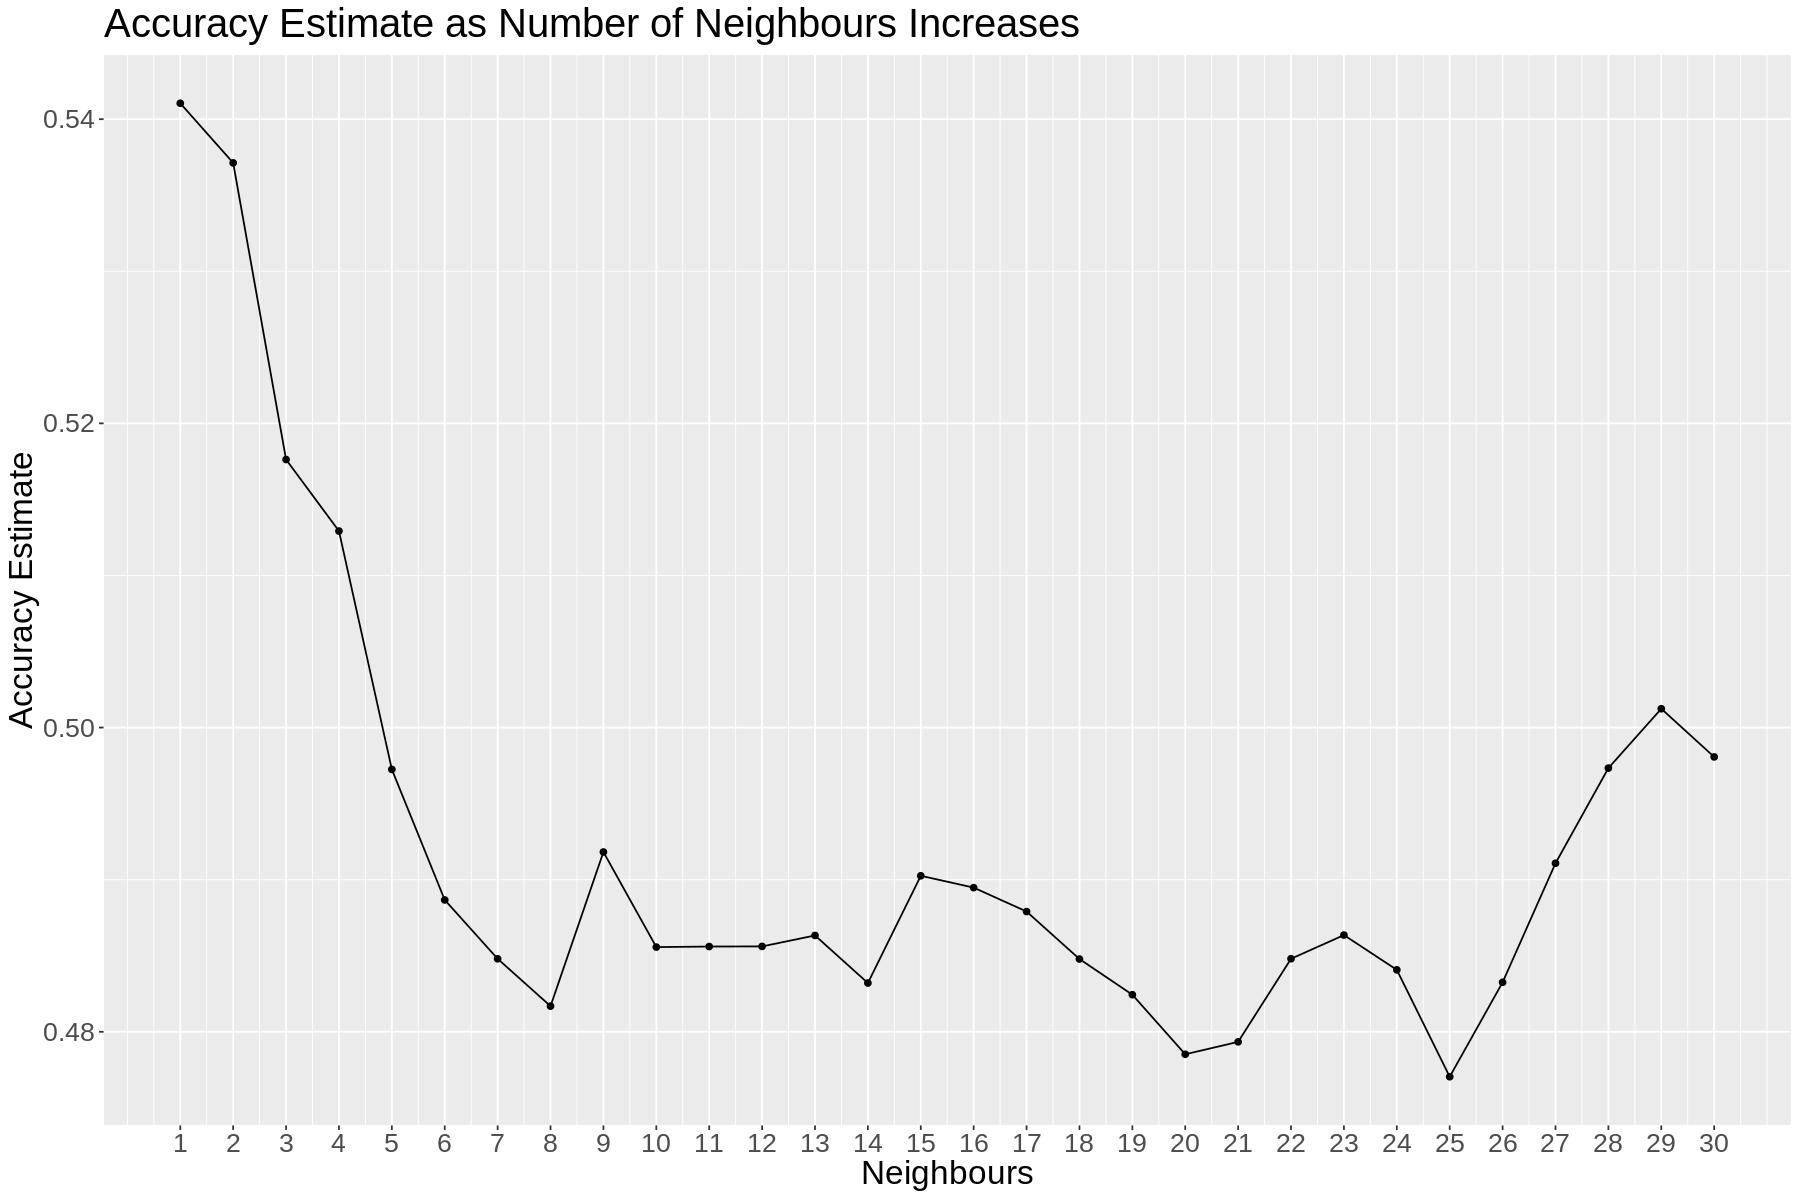

In [ ]:
set.seed(314159265)

wine_vfold <- vfold_cv(wine_train, v = 5, strata = quality)

wine_tune <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") %>%
    set_engine("kknn") %>%
    set_mode("classification")

wine_recipe <- recipe(quality ~ ., data = wine_train) %>%
    step_upsample(quality, over_ratio = 0.2) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

ks <- tibble(neighbors = seq(1, 30))

knn_results <- workflow() %>%
    add_recipe(wine_recipe) %>%
    add_model(wine_tune) %>%
    tune_grid(resamples = wine_vfold, grid = ks) %>%
    collect_metrics()

knn_results %>%
filter(.metric == "accuracy") %>%
ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks = seq(1, 30)) +
    labs(x = "Neighbours", y = "Accuracy Estimate", title = "Accuracy Estimate as Number of Neighbours Increases") +
    theme(text = element_text(size = 20))

# Predicting Class Labels on Test Data 

Based on the results, the optimal k is 9, as this ***K*** value gave us the highest ‘accuracy’ metric without overfitting or underfitting to the validation data. We add the optimal “k” into a new model. Having identified the ideal K value, we use `predict()` to predict the wine quality label of observations in our `wine_test` data using our classification model. Using the `metrics()` function, we then evaluated the accuracy of our classifier on our` wine_test` data.




In [ ]:
# Through trial and error we have determined 9 to be a good choice, although 
# any value on about [5, 12] would probably be fine
neighbours <- 9

# Create classifier with the determined number of neighbours
wine_spec <- nearest_neighbor(neighbors = neighbours, weight_func = "rectangular") %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Create and train workflow
wine_predict <- workflow() %>%
    add_recipe(wine_recipe) %>%
    add_model(wine_spec) %>%
    fit(data = wine_train)

# Predict the quality levels for the test data
wine_predictions <- predict(wine_predict, wine_test) %>%
    bind_cols(wine_test)

# Show the prediction accuracy on the test data
wine_prediction_accuracy <- wine_predictions %>%
    metrics(truth = quality, estimate = .pred_class)
wine_prediction_accuracy

#Confusion Matrix for the classifier
wine_predictions %>%
     conf_mat(truth = quality, estimate = .pred_class)


.metric  .estimator .estimate
1 accuracy multiclass 0.4968553
2 kap      multiclass 0.2162179

          Truth
Prediction  3  4  5  6  7  8
         3  0  1  1  0  0  0
         4  0  2  5  8  1  0
         5  2  5 86 40  7  0
         6  0  2 40 63 23  2
         7  0  0  0  7  6  1
         8  0  0  4  8  3  1

**Assessing Model Accuracy:**
The results from the `metrics` function suggest that our classifier predicted the correct quality label of our test data **56%** of the time. 

# Results 

**Plotting Our Results**

We used a decision-boundary plot to visualize the accuracy of the class label predictions made by our classifier on the `wine_test` data. We created a decision boundary surface that separates vector space into regions using our training data, where each region is assigned a wine quality class label. Next, we overlaid our original data to show how accurately each data point fell into the correct class label. 

In addition, we included the decision-boundary plots for K=2 and K=29 to see if it overfits or underfits despite the high accuracy estimates of these Ks

In [ ]:
# How fine-grained should the classification grid be
granularity <- 300

# Generate data points to be classified at regular intervals
alc_grid <- seq(min(wine_data$alcohol), max(wine_data$alcohol), length.out = granularity)
acid_grid <- seq(min(wine_data$volatile.acidity), max(wine_data$volatile.acidity), length.out = granularity)

# Combine and create all possible combinations of the generated data-points
grid <- as.tibble(expand.grid(alcohol = alc_grid, volatile.acidity = acid_grid))

# Classify all the generated data-points
pred_table <- predict(wine_predict, grid) %>%
    bind_cols(grid)

# Plot the generated data points and the original data
decision_boundary_9 <-
ggplot() +
    # Original data
    geom_point(data = wine_data, mapping = aes(x = alcohol, y = volatile.acidity, color = as_factor(quality)), alpha = 1, size = 2) +
    # Generated data
    geom_point(data = pred_table, mapping = aes(x = alcohol, y = volatile.acidity, color = .pred_class), alpha = 0.03, size = 5) +
    # Labels
    labs(x = "Alcohol", y = "Volatile Acidity", color = "Quality", title = "Wine Quality Classifier Decision Areas with Original Data Overlayed (K = 9)") +
    # Make text legible
    theme(text = element_text(size = 20))

Warning message:
“`as.tibble()` is deprecated as of tibble 2.0.0.
Please use `as_tibble()` instead.
The signature and semantics have changed, see `?as_tibble`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [ ]:
# This shows the decision boundaries for 2 neighbours
# any value on about [5, 12] would probably be fine
neighbours_2 <- 2

# Create classifier with the determined number of neighbours
wine_spec_2 <- nearest_neighbor(neighbors = neighbours_2, weight_func = "rectangular") %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Create and train workflow
wine_predict_2 <- workflow() %>%
    add_recipe(wine_recipe) %>%
    add_model(wine_spec_2) %>%
    fit(data = wine_train)

# How fine-grained should the classification grid be
granularity <- 300

# Generate data points to be classified at regular intervals
alc_grid_2 <- seq(min(wine_data$alcohol), max(wine_data$alcohol), length.out = granularity)
acid_grid_2 <- seq(min(wine_data$volatile.acidity), max(wine_data$volatile.acidity), length.out = granularity)

# Combine and create all possible combinations of the generated data-points
grid_2 <- as.tibble(expand.grid(alcohol = alc_grid_2, volatile.acidity = acid_grid_2))

# Classify all the generated data-points
pred_table_2 <- predict(wine_predict_2, grid_2) %>%
    bind_cols(grid_2)

# Plot the generated data points and the original data
decision_boundary_2 <-
ggplot() +
    # Original data
    geom_point(data = wine_data, mapping = aes(x = alcohol, y = volatile.acidity, color = as_factor(quality)), alpha = 1, size = 2) +
    # Generated data
    geom_point(data = pred_table_2, mapping = aes(x = alcohol, y = volatile.acidity, color = .pred_class), alpha = 0.03, size = 5) +
    # Labels
    labs(x = "Alcohol", y = "Volatile Acidity", color = "Quality", title = "Wine Quality Classifier Decision Areas with Original Data Overlayed (K = 2)") +
    # Make text legible
    theme(text = element_text(size = 20))

In [ ]:
# This shows the decision boundaries for 29 neighbours
# any value on about [5, 12] would probably be fine
neighbours_29 <- 29

# Create classifier with the determined number of neighbours
wine_spec_29 <- nearest_neighbor(neighbors = neighbours_29, weight_func = "rectangular") %>%
    set_engine("kknn") %>%
    set_mode("classification")

# Create and train workflow
wine_predict_29 <- workflow() %>%
    add_recipe(wine_recipe) %>%
    add_model(wine_spec_29) %>%
    fit(data = wine_train)

# How fine-grained should the classification grid be
granularity <- 300

# Generate data points to be classified at regular intervals
alc_grid_29 <- seq(min(wine_data$alcohol), max(wine_data$alcohol), length.out = granularity)
acid_grid_29 <- seq(min(wine_data$volatile.acidity), max(wine_data$volatile.acidity), length.out = granularity)

# Combine and create all possible combinations of the generated data-points
grid_29 <- as.tibble(expand.grid(alcohol = alc_grid_29, volatile.acidity = acid_grid_29))

# Classify all the generated data-points
pred_table_29 <- predict(wine_predict_29, grid_29) %>%
    bind_cols(grid_29)

# Plot the generated data points and the original data
decision_boundary_29 <- 
ggplot() +
    # Original data
    geom_point(data = wine_data, mapping = aes(x = alcohol, y = volatile.acidity, color = as_factor(quality)), alpha = 1, size = 2) +
    # Generated data
    geom_point(data = pred_table_29, mapping = aes(x = alcohol, y = volatile.acidity, color = .pred_class), alpha = 0.03, size = 5) +
    # Labels
    labs(x = "Alcohol", y = "Volatile Acidity", color = "Quality", title = "Wine Quality Classifier Decision Areas with Original Data Overlayed (K = 29)") +
    # Make text legible
    theme(text = element_text(size = 20))

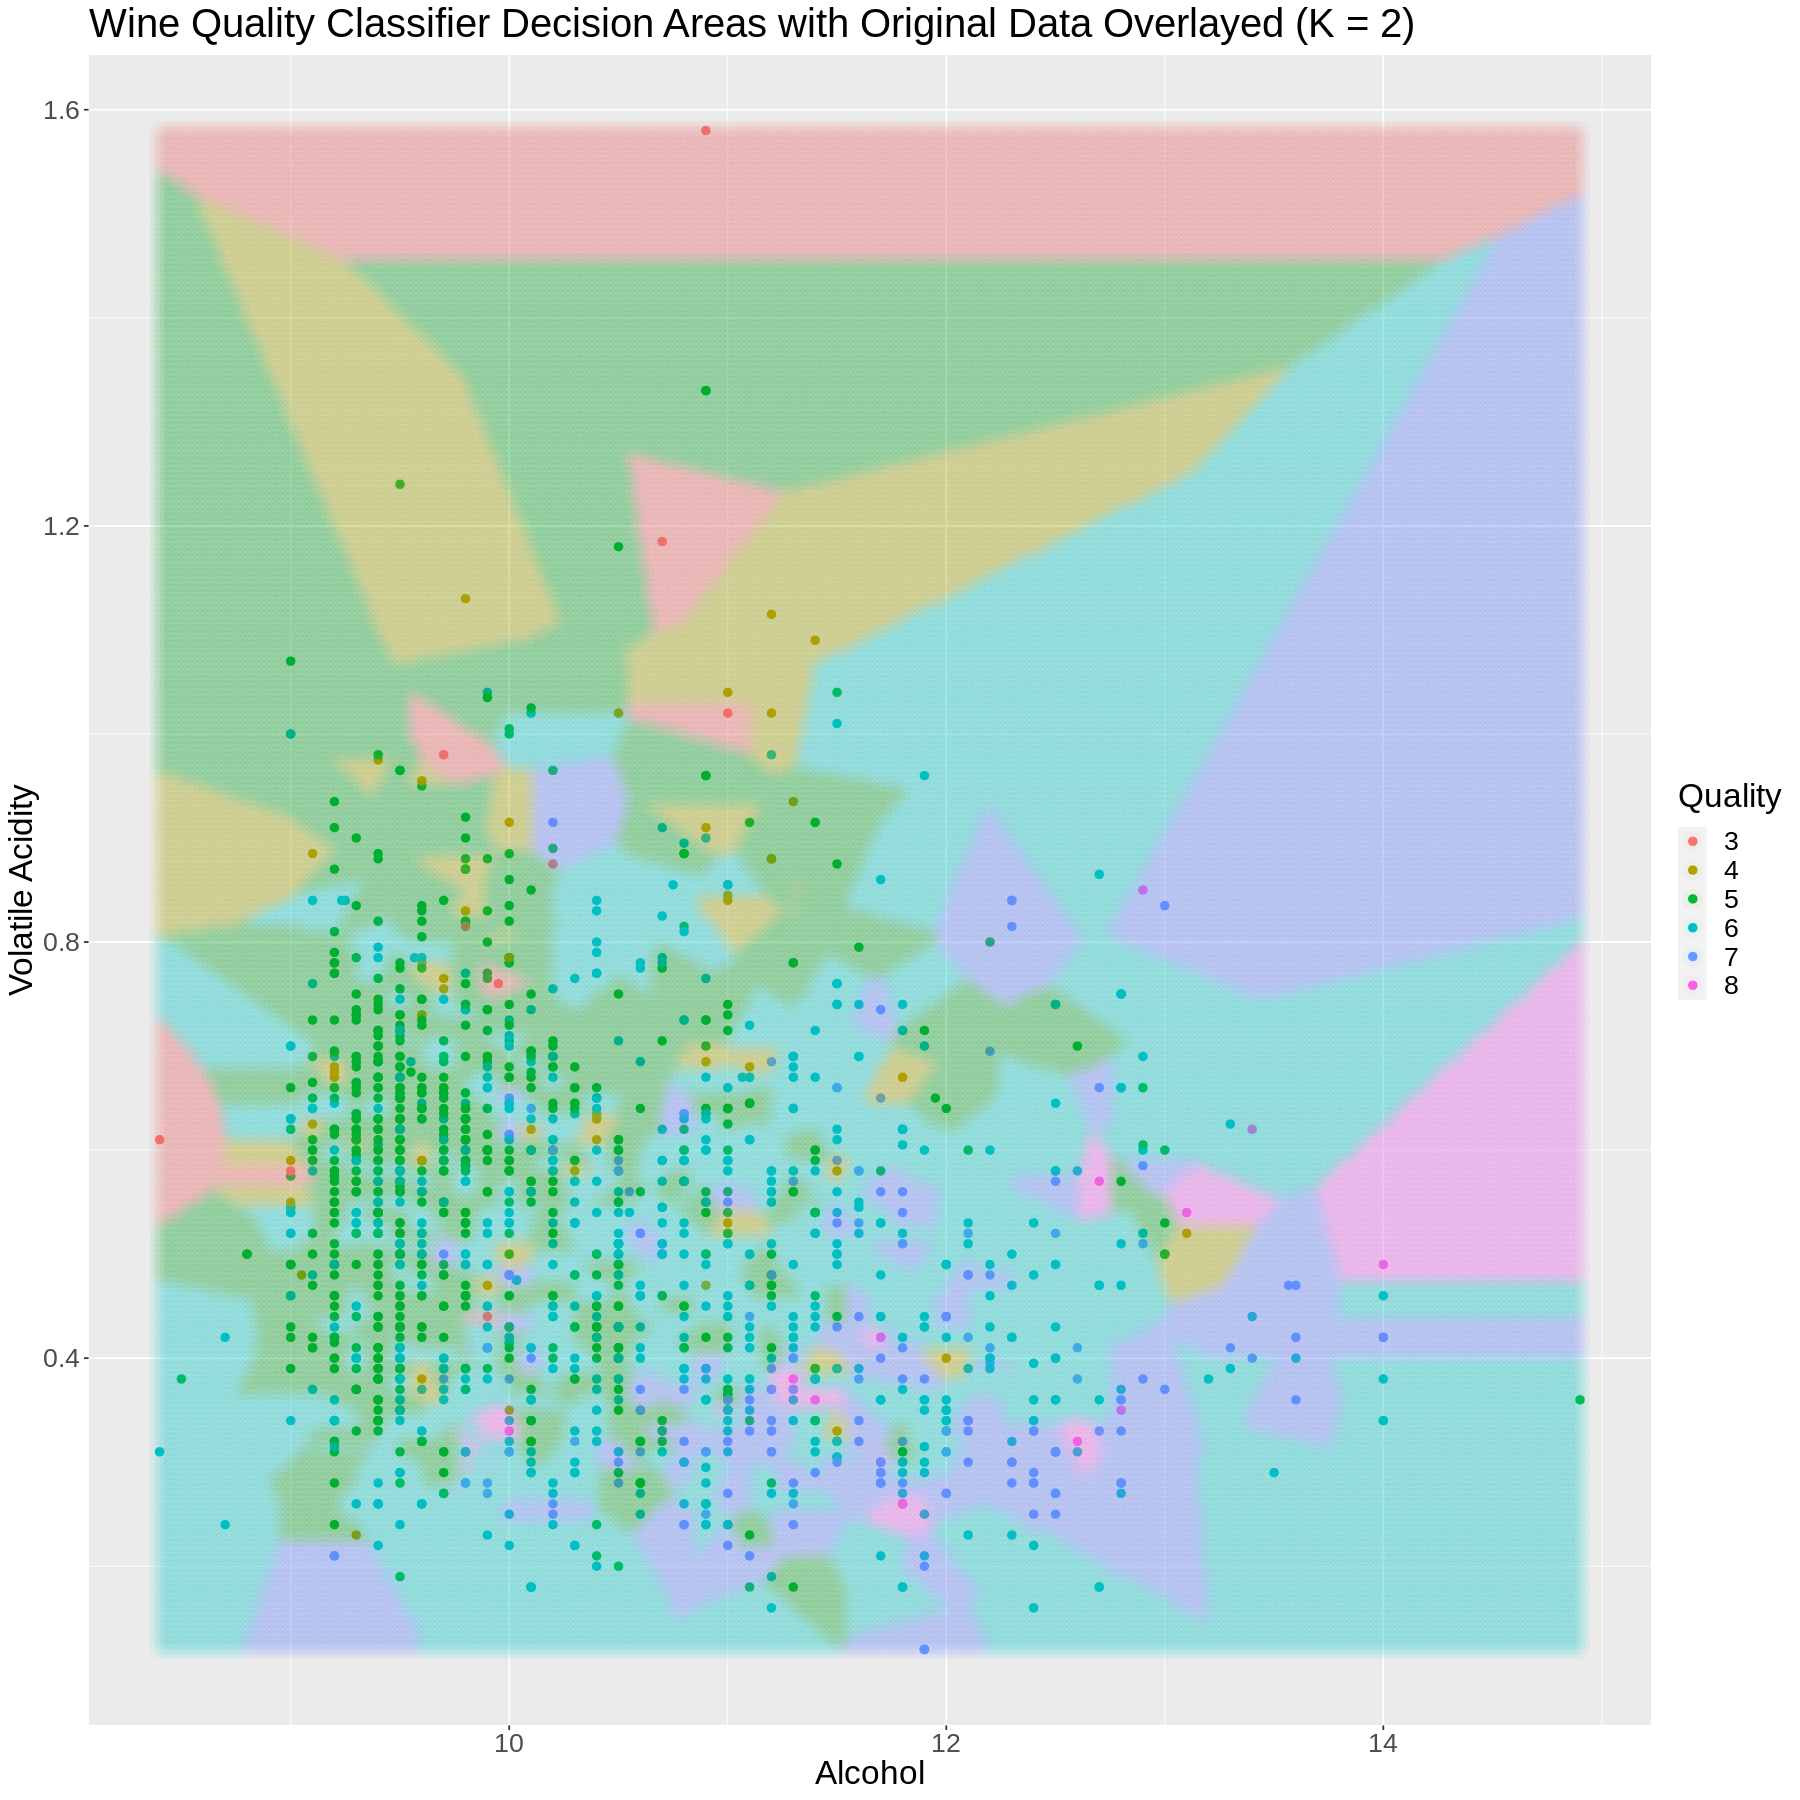

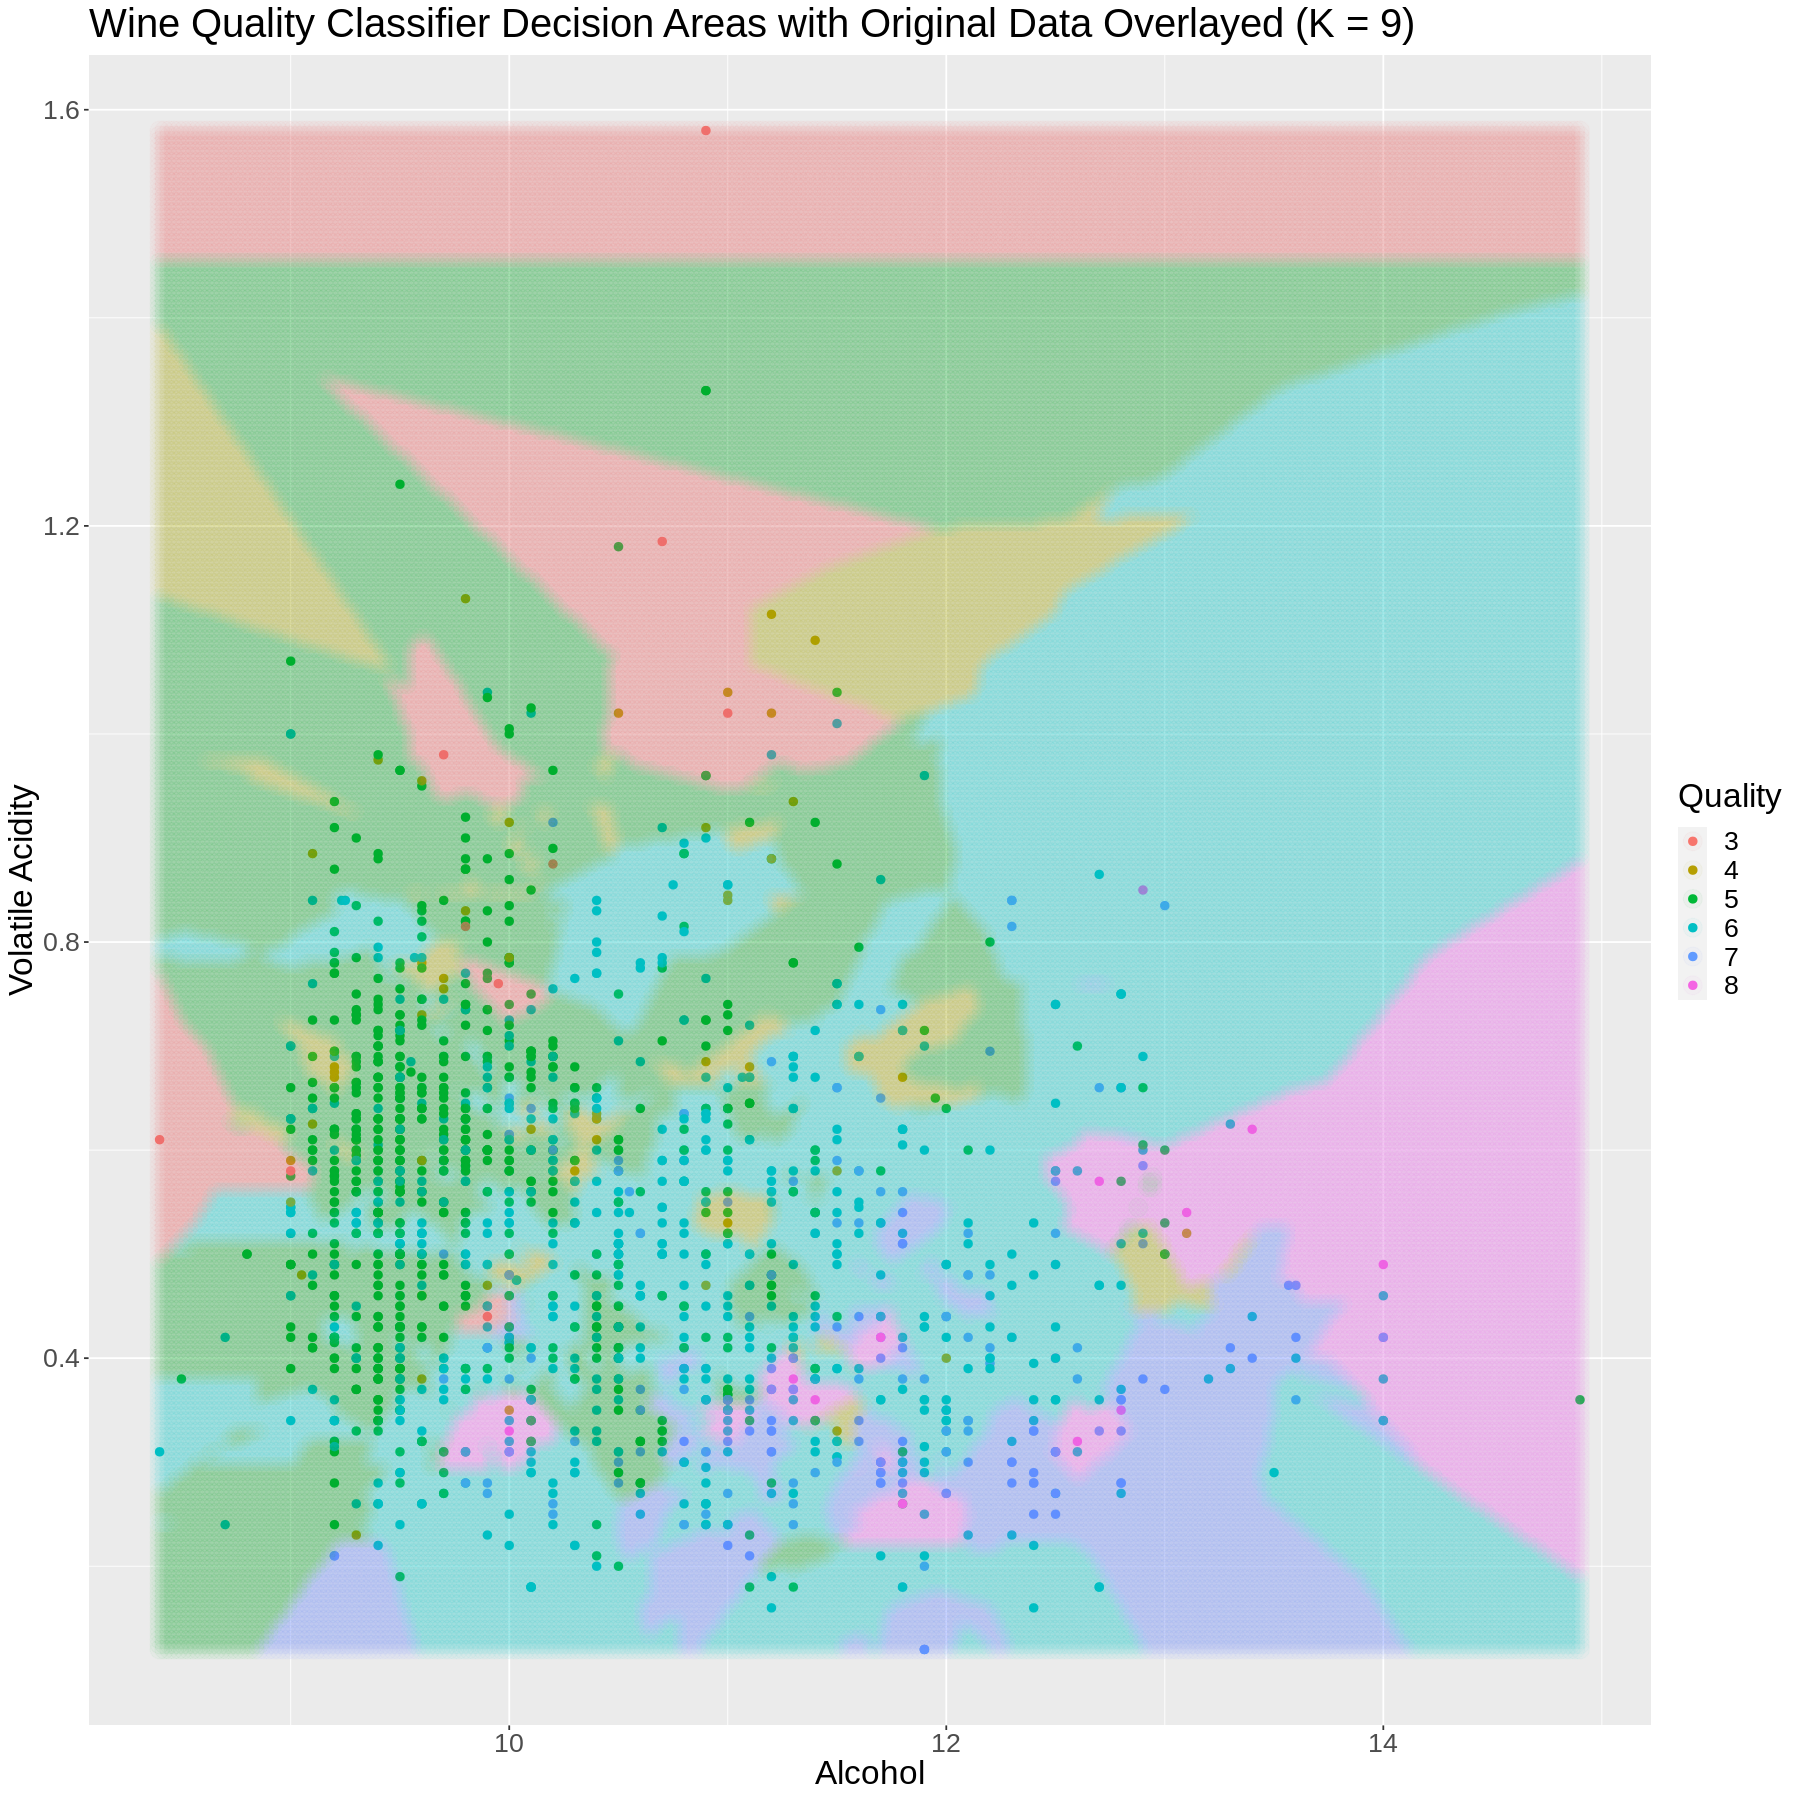

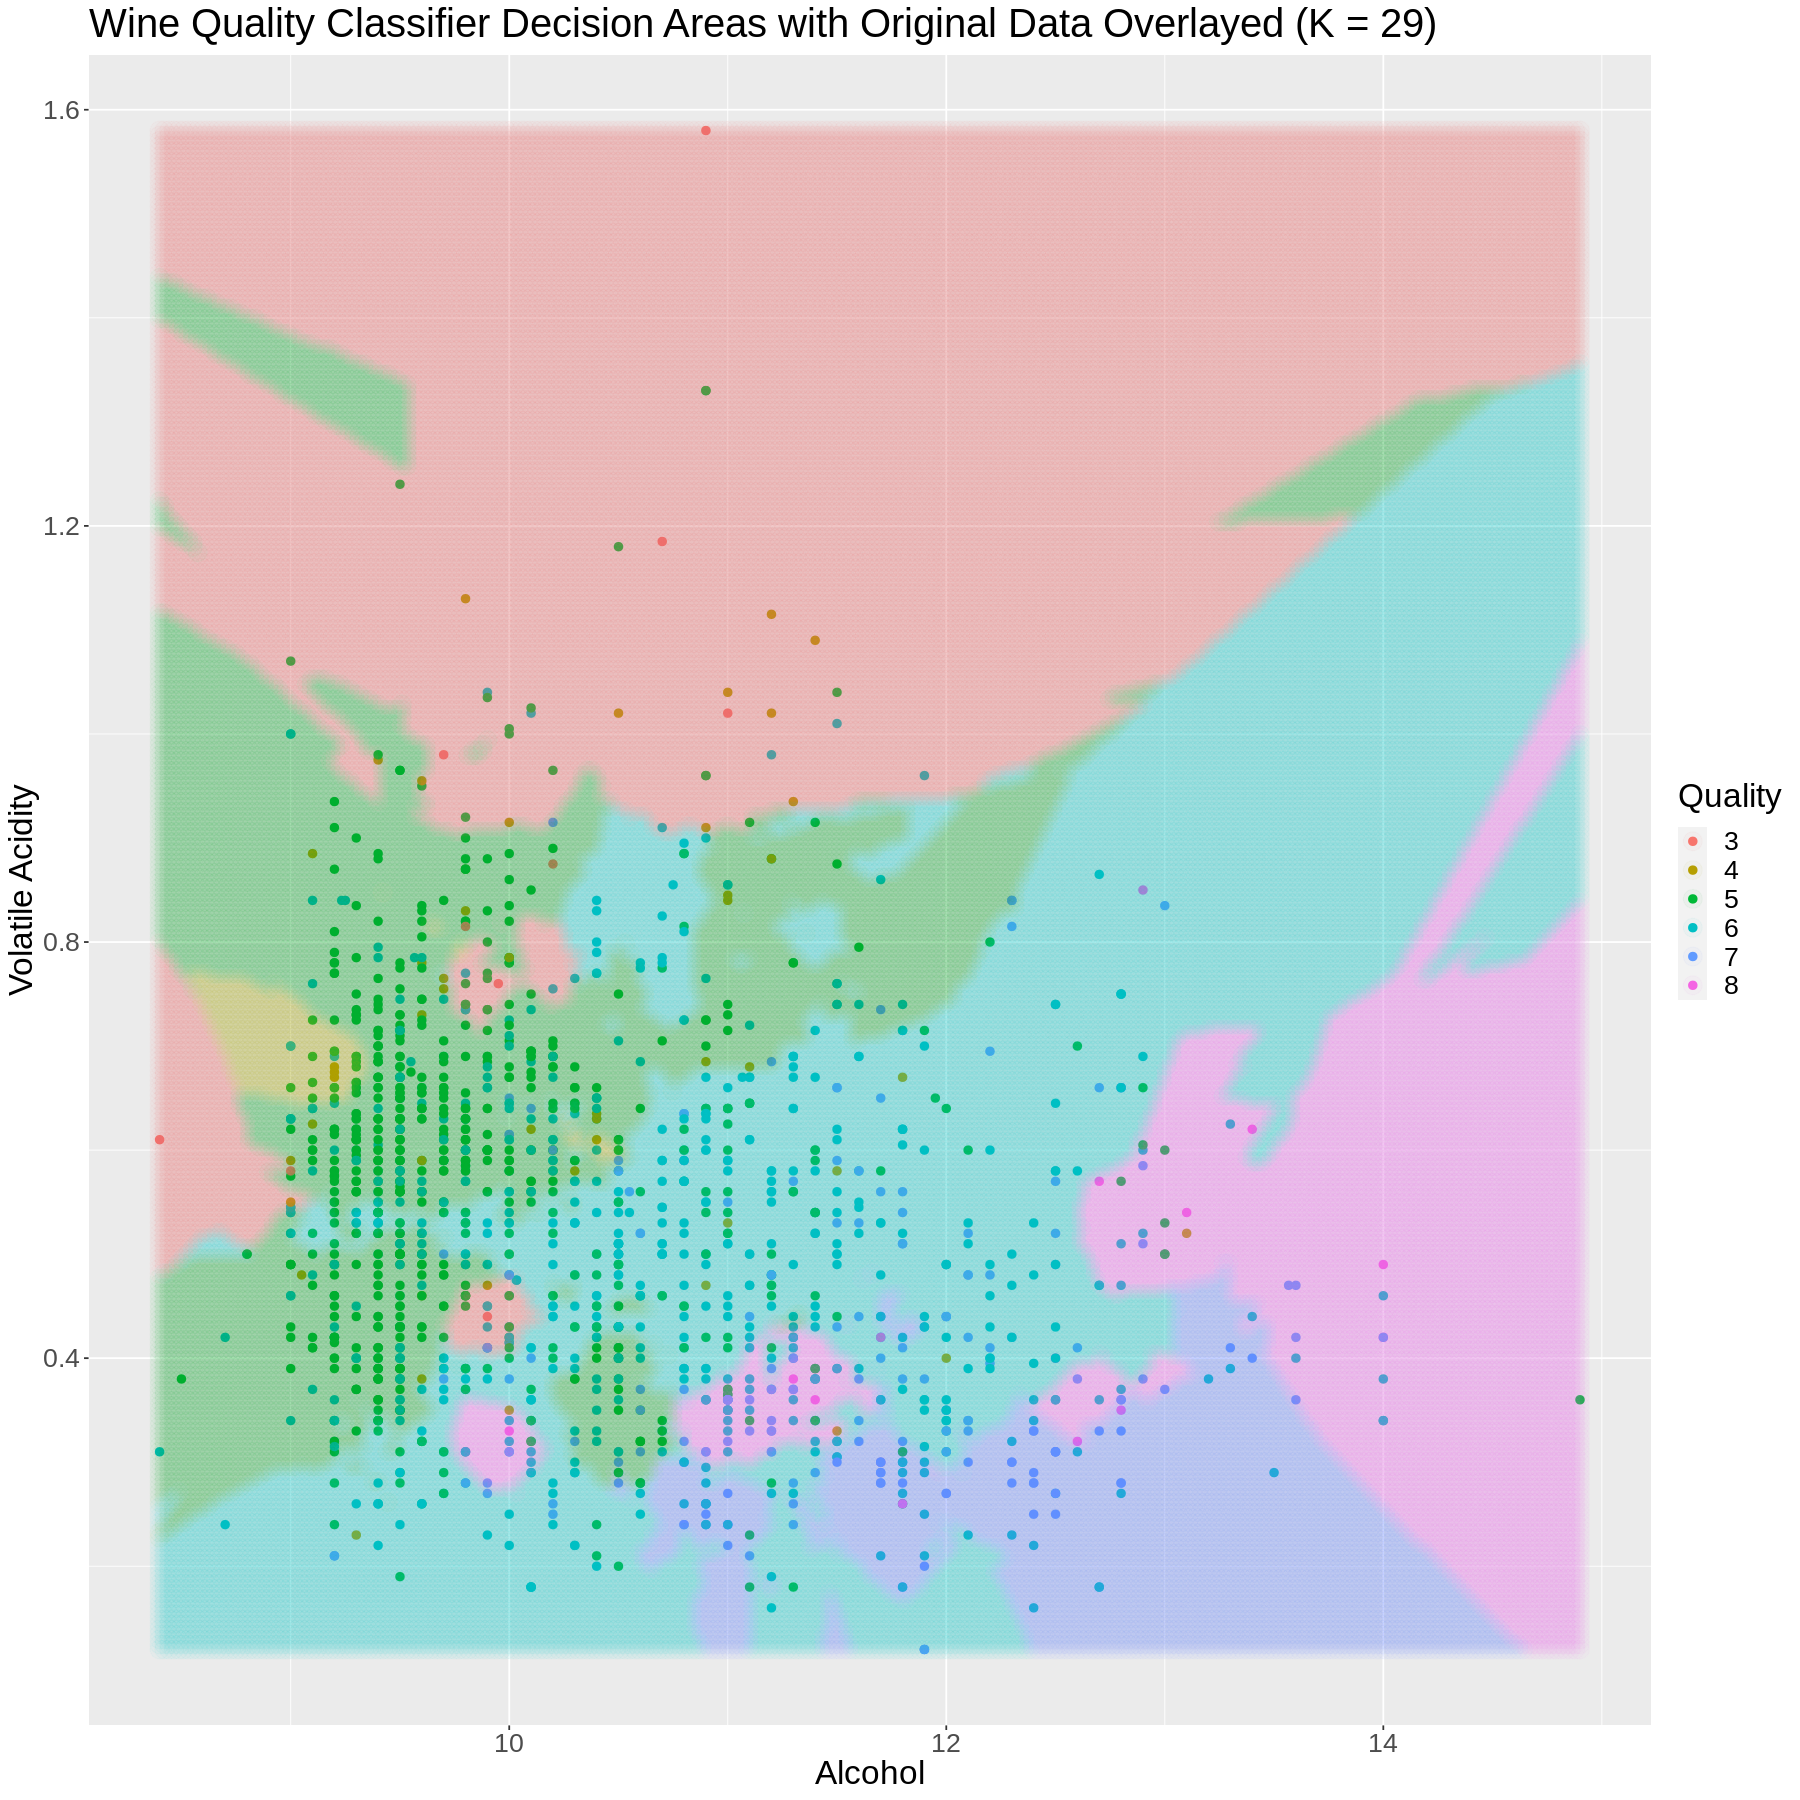

In [ ]:
options(repr.plot.height = 15, repr.plot.width = 15)

decision_boundary_2

decision_boundary_9

decision_boundary_29

With the decision-boundary plot of K=2, we can see that our model overfits the data. Certain areas of the plot, especially the centre, pick up "noise" from the data so the model defines the boundaries for wine classes less accurately. 

For the decision-boundary of K=29, we can see that model is underfitting because of the "averaging effect" on the boundaries and wine class 4 doesn't appear much on the plot.

To avoid underfitting or overfitting the data, we decided that K=9 is the ideal number of neighbours. Although the boundaries of the plot are still slightly rough, K=9 provides distinct areas for wine classes without overfitting to noise from the data. 

#Discussion

**Results Summary**

The results of this analysis show that it is possible to use KNN classification to predict wine quality with 51% accuracy using the variables of volatile acidity and alcohol content . While the red wine dataset contains 1599 observations, most of the wine quality ratings are for classes 5 & 6. There are no quality ratings for wines below 3 or wines above 8. The narrow set of observations is a limitation on the accuracy of our model to predict high quality and low quality wines. We expected to find that attributes such as higher alcohol content, sulphates, and residual sugar would result in higher quality wines, as these are the features that wine critics often reference as attributes of  high quality wines. However, our analysis revealed that only volatile acidity and alcohol content were the most highly correlated to high quality wines. 

**Significance of Findings**

Our analysis found that it was possible to use physiochemical properties in the wine_test to predict the quality of wines with 51% accuracy. While the model is not able to predict wine quality with high precision, it is far above random prediction, as we would expect random prediction to be accurate approximately 16% of the time.  The ability to use knn classification to predict wine quality with 51% accuracy is a promising basis for the future development and refinement of wine quality classification models. Quality ratings are a major factor that affects the export of wines, as most potential wholesale importers research the expert wine quality ratings of the wine prior to placing an order (*Gawel et. al, 2008*). To enhance standardization of wine quality ratings in wine-exporting regions, wineries could send samples of their wine to wine laboratories for physicochemical  analysis. Laboratories could employ a classification model to cross-reference the wine quality rating  assigned by wine critics. The classifier could be used to flag wine quality ratings that are either far above or below what is predicted by the classifier. The introduction of physiochemical analysis of wine quality would have significant implications for standardization of wine exports. 

**Future Directions & Research Questions**

Our findings are applicable to research human subjectivity in wine quality ratings. The findings of this analysis are relevant for structure studies into how red wine quality ratings are affected by the subjective judgements of wine critics.  A classification model that predicts the quality of wine based on physicochemical wine properties --such as the one created for this project-- could be used to compare predicted wine quality rating against the rating given by a critic. A substantial difference between the predicted quality of the wine versus its critic-assigned rating could help to identify highly subjective wine critics. Future research could investigate the following questions: 

- Do findings in this analysis also extend to white wines?
- Does our classification model generalize well over the different types of red wine (e.g wines from different regions and wines of different ages)? 


# References

Diako, Charles. "Influence of Wine Components on the Chemical and Sensory Quality of Wines." *PhD Dissertation, Washington State University*. 2016.

Gawel, R. and P. W. Godden. "Evaluation of the Consistency of Wine Quality Assessments from Expert Wine Tasters." *Australian Journal of Grape and Wine Research* 14, no. 1 (2008): 1-8.

UCI Machine Learning, “Red Wine Quality”, 2017. Accessed November 1st, 2020. 
https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009 